<a href="https://colab.research.google.com/github/DarshanGowda0/MusicalInstrumentsClassification/blob/main/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurations

In [ ]:
INSTRUMENTS = ['flu', 'pia', 'tru', 'gac', 'voi', 'org']

DATASET_CHOSEN = 'mean'

if DATASET_CHOSEN == 'mean':
  DATA_PATH = '/content/drive/MyDrive/CS6140 ML Group Project/Dataset/Xiaoyu/6-instruments-20-mfcc-26-features-mean.csv'
elif DATASET_CHOSEN == 'expanded_mfcc':
  DATA_PATH = '/content/drive/MyDrive/CS6140 ML Group Project/Dataset/Final Day datasets/mfcc-16-128-and-other-features.h5'
elif DATASET_CHOSEN == 'autoencoder':
  DATA_PATH = '/content/drive/MyDrive/CS6140 ML Group Project/Dataset/Final Day datasets/Copy of mfcc-autoencoder-simple-reduced.h5'

# Preparations

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install and import packages

In [ ]:
import os
import itertools
import pandas as pd
import numpy as np
import statistics
import seaborn as sns #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.utils import shuffle
from sklearn.utils.fixes import loguniform

In [ ]:
# https://stackoverflow.com/a/54294640
!pip install --upgrade tables

Requirement already up-to-date: tables in /usr/local/lib/python3.7/dist-packages (3.6.1)


## Utility functions

In [ ]:
def plot_confusion_matrix(cnf_matrix):
  df_cm = pd.DataFrame(cnf_matrix, index=INSTRUMENTS, columns=INSTRUMENTS)
  plt.figure(figsize = (10,7))
  sns.set(font_scale=1.0) #for label size
  sns.heatmap(df_cm, annot=True, annot_kws={'size': 18}, fmt='g') # font size
  plt.show()

In [ ]:
def display_score(y_test, y_pred):
  print('Recall: ', recall_score(y_test, y_pred, average=None))
  print('Precision: ', precision_score(y_test, y_pred, average=None))
  print('F1-Score: ', f1_score(y_test, y_pred, average=None))
  print('Accuracy: %.2f ' % accuracy_score(y_test, y_pred, normalize=True))
  print('Number of samples: ', y_test.shape[0])

In [ ]:
def cross_validation(clf, X, y):
  scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
  print('Cross validation score: ', statistics.mean(scores))

## Load data

In [ ]:
if DATASET_CHOSEN == 'mean':
  df = pd.read_csv(DATA_PATH)
elif DATASET_CHOSEN == 'expanded_mfcc':
  df = pd.read_hdf(DATA_PATH, key='s')
elif DATASET_CHOSEN == 'autoencoder':
  df = pd.read_hdf(DATA_PATH, key='s')

In [ ]:
df = df.loc[df['label'].isin(INSTRUMENTS)]
df = shuffle(df)
df.head()

,Unnamed: 0,chroma_stft_mean,rms_mean,spectral_centroid_mean,spectral_bandwidth_mean,rolloff_mean,zero_crossing_rate_mean,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,mfcc11_mean,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,label
334,334,0.322268,0.025117,735.979646,974.956826,1244.039401,0.039062,-389.395081,210.049286,-15.830007,28.425850,8.662963,-9.919877,-13.232139,5.107346,-10.676975,-8.834652,-1.889245,-10.734410,-16.543196,-11.608549,-5.270324,-1.224172,-7.875258,-6.441239,-9.334398,-6.548956,gac
3762,3762,0.251637,0.071346,2867.629437,1962.938804,4537.791279,0.200428,-241.932037,34.706116,-59.357269,14.840032,-44.193321,-4.039587,17.545931,-26.755285,2.322680,16.005375,-20.640877,0.692968,-7.267929,0.855768,-1.347395,-11.183808,-7.221368,0.399782,-4.159951,15.742435,voi
2132,2132,0.505965,0.155043,2091.323272,2596.246118,4943.443697,0.062816,-95.850815,92.662254,4.342888,30.605413,14.906110,19.721544,8.774365,10.183359,3.799057,7.132329,-3.325059,0.206675,-0.116133,8.447940,-2.605480,-1.020215,-3.885080,3.711197,-4.448688,-0.143625,gac
3639,3639,0.206823,0.010146,733.519227,908.852996,1116.330942,0.062842,-499.489960,227.252487,2.671182,-12.962892,-4.383070,9.372667,22.878290,11.861219,0.842757,-11.840935,-19.670542,0.720194,13.149297,2.023502,-12.249653,-6.666698,-8.615514,-18.073517,-2.359622,17.853062,pia
775,775,0.370517,0.158712,2540.169075,2690.740531,5584.553410,0.111888,-58.628792,83.722145,5.243917,21.501074,-6.251448,10.365317,1.274225,1.850703,2.657917,8.662865,-2.671222,3.817735,-10.381803,1.404550,-5.613657,-9.318715,-11.361321,8.037890,-9.862604,0.918842,voi


In [ ]:
if DATASET_CHOSEN == 'expanded_mfcc':
  mfcc = df.loc[:, 'mfcc'].to_numpy()
  mfcc = np.array([np.array(x) for x in mfcc])
  mfcc = mfcc.reshape(mfcc.shape[0], mfcc[0].shape[0] * mfcc[0].shape[1])
  mfcc.shape

In [ ]:
if DATASET_CHOSEN == 'mean':
  X = df.drop(['label', df.columns[0]], axis=1)
elif DATASET_CHOSEN == 'expanded_mfcc':
  X = df.drop(['mfcc', 'label'], axis=1).to_numpy()
  X = np.concatenate((mfcc, X), axis=1)
elif DATASET_CHOSEN == 'autoencoder':
  X = df['encoder_features'].to_numpy()
  X = np.array([x.reshape((X[0].shape[0],)) for x in X])

X.shape

(3846, 26)

In [ ]:
y = df.loc[:, 'label'].to_numpy()
y.shape

(3846,)

## Data exploration

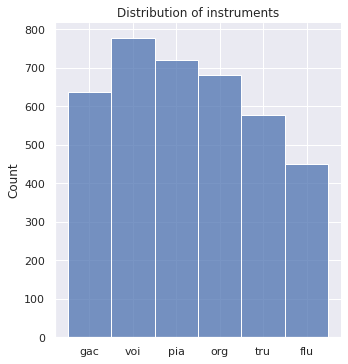

In [ ]:
sns.displot(data=y).set(title='Distribution of instruments')

## Preprocess data 

### Rescale data

TODO: Explain why we need to rescale 

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X[0]

array([ 0.2491377 , -1.18852224, -1.48139169, -1.58036873, -1.41027222,
       -1.12753217, -1.49040555,  2.04657261, -0.31117837,  0.20995002,
        0.51873463, -1.60985365, -1.19437204,  0.3091115 , -0.66622193,
       -1.22139468,  0.45028329, -1.54216719, -1.72483851, -1.70312741,
       -0.08305546, -0.15538138, -0.55848712, -0.97631684, -0.81796225,
       -0.87238601])

### Encode labels

Labels are 3-character codes for instruments, e.g., 'pia' representing piano. We'll need encode these codes to numbers in order to train and test on them.

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)
y[0]

1

## Split training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

print(f'Size of training set: {len(X_train)}')
print(f'Size of testing set: {len(X_test)}')

Size of training set: 3269
Size of testing set: 577


# SVM

## RBF

TODO: Explain RBF

#### Training with hyperparameters tuning

TODO:
- Randomized parameter optimization: https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization

- Explain C and gamma (models with very large gamma values tend to overfit)

- Explain why using accuracy as the scoring metric (because classes are equally important) https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/

In [ ]:
svc_estimator = SVC()

param_distributions = { 
  'C': loguniform(1e-1, 1e3),
  'gamma': loguniform(1e-4, 1e0), 
  'kernel': ['rbf'],
}

svc_cv = RandomizedSearchCV(svc_estimator, param_distributions, n_iter=10)
svc_cv.fit(X_train, y_train)
svc_cv.best_params_

{'C': 9.360214694841458, 'gamma': 0.10397932071645144, 'kernel': 'rbf'}

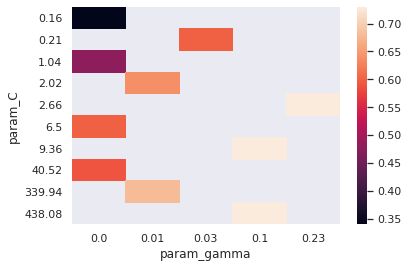

In [ ]:
svc_cv_results_df = pd.DataFrame({
  'param_C': svc_cv.cv_results_['param_C'],
  'param_gamma': svc_cv.cv_results_['param_gamma'],
  'mean_test_score': svc_cv.cv_results_['mean_test_score'],
})
svc_cv_results_df = np.round(svc_cv_results_df.astype(float), 2)
svc_cv_results_df = svc_cv_results_df.pivot('param_C', 'param_gamma', 'mean_test_score')
sns.heatmap(svc_cv_results_df)

### Evaluation

In [ ]:
y_pred = svc_cv.predict(X_test)
display_score(y_test, y_pred)

Recall:  [0.7        0.83157895 0.82828283 0.87       0.72727273 0.83064516]
Precision:  [0.62686567 0.88764045 0.74545455 0.77678571 0.8372093  0.91150442]
F1-Score:  [0.66141732 0.85869565 0.784689   0.82075472 0.77837838 0.86919831]
Accuracy: 0.81 
Number of samples:  577


#### Confusion matrix

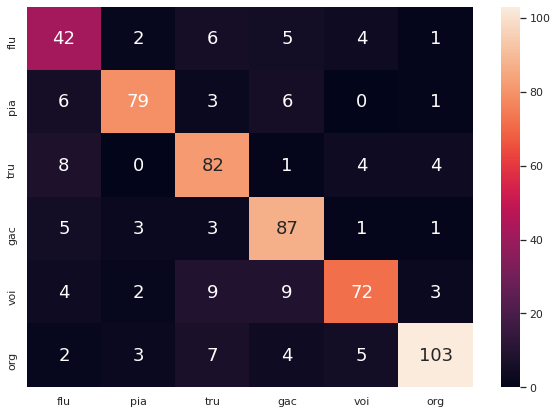

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix)  

## Polynomial

#### Training with hyperparameters tuning

TODO:
- Randomized parameter optimization: https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization

- Explain C and gamma (models with very large gamma values tend to overfit)

- Explain why using accuracy as the scoring metric (because classes are equally important) https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/

In [ ]:
svc_estimator = SVC()

param_distributions = { 
  'degree': range(2, 8),
  'coef0': loguniform(1e-2, 1e1), 
  'kernel': ['poly'],
}

svc_cv = RandomizedSearchCV(svc_estimator, param_distributions, n_iter=10)
svc_cv.fit(X_train, y_train)
svc_cv.best_params_

{'coef0': 0.39422893971557593, 'degree': 5, 'kernel': 'poly'}

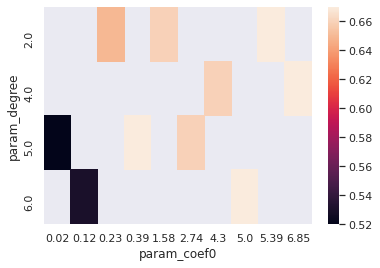

In [ ]:
svc_cv_results_df = pd.DataFrame({
  'param_degree': svc_cv.cv_results_['param_degree'],
  'param_coef0': svc_cv.cv_results_['param_coef0'],
  'mean_test_score': svc_cv.cv_results_['mean_test_score'],
})
svc_cv_results_df = np.round(svc_cv_results_df.astype(float), 2)
svc_cv_results_df = svc_cv_results_df.pivot('param_degree', 'param_coef0', 'mean_test_score')
sns.heatmap(svc_cv_results_df)

### Evaluation

In [ ]:
y_pred = svc_cv.predict(X_test)
display_score(y_test, y_pred)

Recall:  [0.56666667 0.75789474 0.75757576 0.82       0.58585859 0.83870968]
Precision:  [0.61818182 0.79120879 0.70093458 0.71304348 0.87878788 0.72727273]
F1-Score:  [0.59130435 0.77419355 0.72815534 0.7627907  0.7030303  0.77902622]
Accuracy: 0.74 
Number of samples:  577


#### Confusion matrix

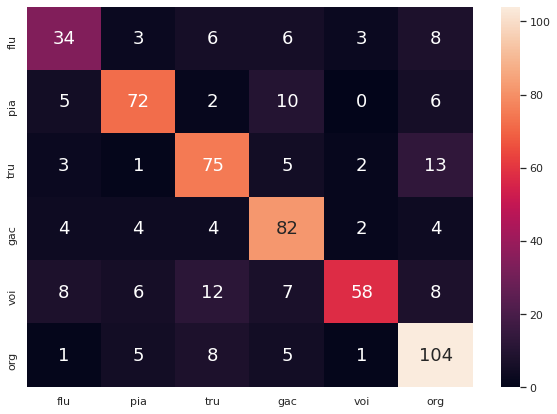

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix)  

## Linear

### Training

In [ ]:
lin_clf = LinearSVC()
lin_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### Evaluation

In [ ]:
y_pred = lin_clf.predict(X_test)
display_score(y_test, y_pred)

Recall:  [0.36666667 0.63157895 0.74747475 0.7        0.43434343 0.72580645]
Precision:  [0.55       0.68181818 0.592      0.60869565 0.68253968 0.61643836]
F1-Score:  [0.44       0.6557377  0.66071429 0.65116279 0.5308642  0.66666667]
Accuracy: 0.62 
Number of samples:  577


#### Confusion matrix

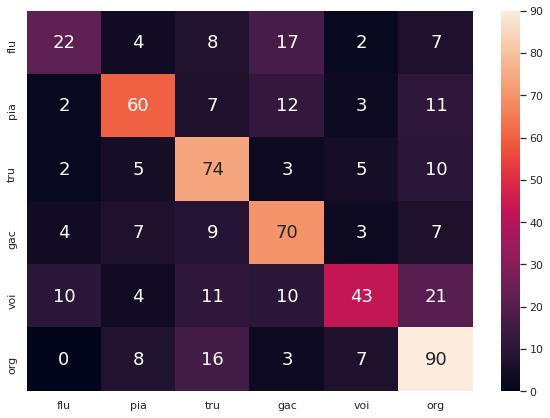

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix)  

## PCA on all features

In [ ]:
from sklearn import decomposition
pca = decomposition.PCA()

In [ ]:
pca.n_components = X.shape[1]
pca_data = pca.fit_transform(X)


In [ ]:
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

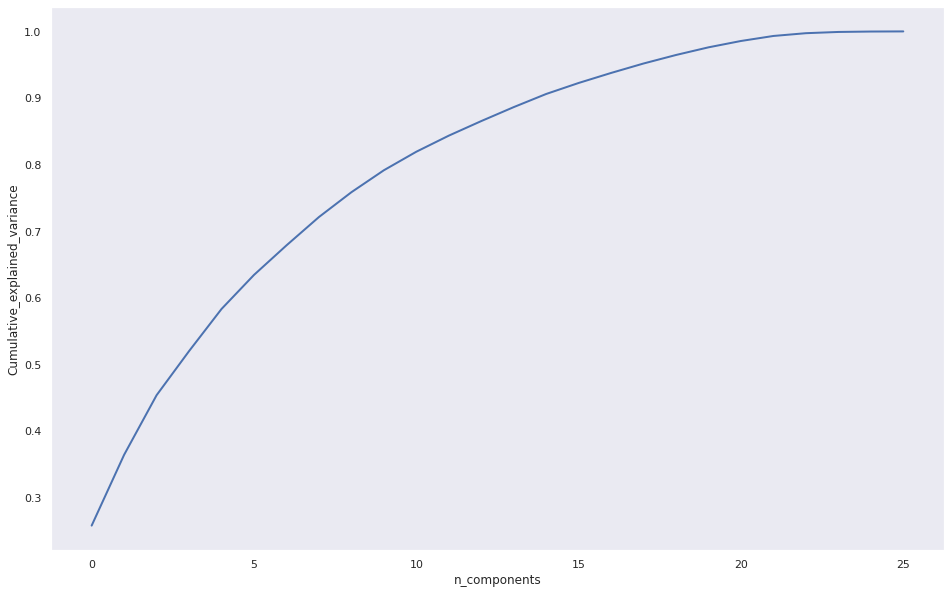

In [ ]:
import matplotlib.pyplot as plt

plt.figure(1, figsize=(16, 10))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

90% of the variance is explained in the first 250 prinicipal components of 2045, which should be enough and our data is reduced to about 10%

## PCA and transform features to top 250 principle components

In [ ]:
pca = decomposition.PCA()
pca.n_components = 60
pca_data = pca.fit_transform(X)

ValueError: ignored

In [ ]:
pca_data.shape

In [ ]:
reduced_df = pd.DataFrame(zip(pca_data, y), columns=['pca_features', 'label'])
reduced_df.to_hdf('/content/drive/MyDrive/mfcc-and-other-pca-reduced.h5', key='s', mode='w')

In [ ]:
reduced_df

## RBF

TODO: Explain RBF

#### Training with hyperparameters tuning

TODO:
- Randomized parameter optimization: https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization

- Explain C and gamma (models with very large gamma values tend to overfit)

- Explain why using accuracy as the scoring metric (because classes are equally important) https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/

In [ ]:
X =  reduced_df['pca_features'].to_numpy()
X = np.array([x.reshape((X[0].shape[0],)) for x in X])
X.shape

In [ ]:
y = reduced_df['label'].to_numpy()
y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

print(f'Size of training set: {len(X_train)}')
print(f'Size of testing set: {len(X_test)}')

In [ ]:
svc_estimator = SVC()

param_distributions = { 
  'C': loguniform(1e-1, 1e3),
  'gamma': loguniform(1e-4, 1e0), 
  'kernel': ['rbf'],
}

svc_cv = RandomizedSearchCV(svc_estimator, param_distributions, n_iter=10)
svc_cv.fit(X_train, y_train)
svc_cv.best_params_

In [ ]:
svc_cv_results_df = pd.DataFrame({
  'param_C': svc_cv.cv_results_['param_C'],
  'param_gamma': svc_cv.cv_results_['param_gamma'],
  'mean_test_score': svc_cv.cv_results_['mean_test_score'],
})
svc_cv_results_df = np.round(svc_cv_results_df.astype(float), 2)
svc_cv_results_df = svc_cv_results_df.pivot('param_C', 'param_gamma', 'mean_test_score')
sns.heatmap(svc_cv_results_df)

### Evaluation

In [ ]:
y_pred = svc_cv.predict(X_test)
display_score(y_test, y_pred)

#### Confusion matrix

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix)  